In [ ]:
#Install packages and import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
print('Imported')

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imported


initial_occupations shape:(3039, 14)
initial_occupations columns: Index(['conceptType', 'conceptUri', 'iscoGroup', 'preferredLabel', 'altLabels',
       'hiddenLabels', 'status', 'modifiedDate', 'regulatedProfessionNote',
       'scopeNote', 'definition', 'inScheme', 'description', 'code'],
      dtype='object')
initial_skills shape:(13939, 13)
initial_skills columns: Index(['conceptType', 'conceptUri', 'skillType', 'reuseLevel',
       'preferredLabel', 'altLabels', 'hiddenLabels', 'status', 'modifiedDate',
       'scopeNote', 'definition', 'inScheme', 'description'],
      dtype='object')
initial_relations shape:(129004, 4)
initial_relations columns:Index(['occupationUri', 'relationType', 'skillType', 'skillUri'], dtype='object')
selected_occupations columns: Index(['preferredLabel', 'description', 'conceptUri'], dtype='object')
selected_skills columns: Index(['conceptUri', 'preferredLabel'], dtype='object')
selected_relations columns:Index(['occupationUri', 'skillUri'], dtype='objec

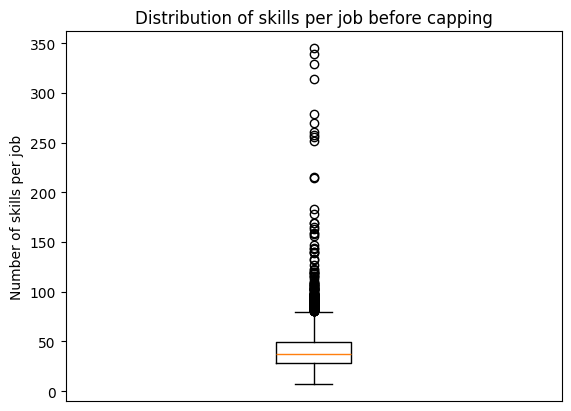

capped_careers shape:(123150, 3)
capped_careers columns:Index(['Career Path', 'Description', 'Skills'], dtype='object')
Min after capping:7
Max after capping:80


<ipython-input-2-0a31902f03f3>:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  capped_careers= renamed_careers.groupby("Career Path").apply(limit_skills).reset_index(drop=True)


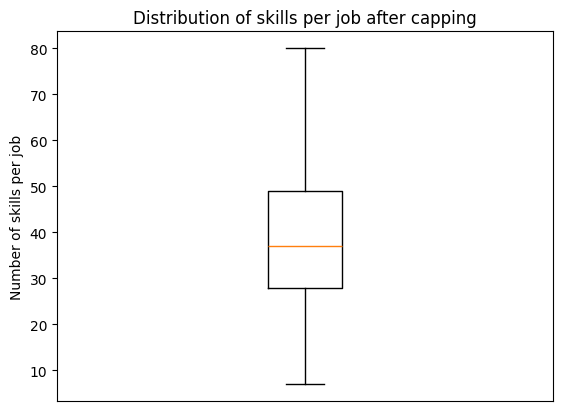

grouped_careers shape:(3039, 2)
grouped_careers columns:Index(['Career Path', 'Skills'], dtype='object')
final_careers shape:(3039, 3)
final_careers columns:Index(['Career Path', 'Skills', 'Description'], dtype='object')
Career Path    0
Skills         0
Description    0
dtype: int64


In [ ]:
#Load data and data preprocessing

#Read the 3 ESCO CSV files containing occupations, skills and their connections
initial_occupations=pd.read_csv("../datasets/occupations_en.csv")
initial_skills=pd.read_csv("../datasets/skills_en.csv")
initial_relations=pd.read_csv("../datasets/occupationSkillRelations_en.csv")
print("initial_occupations shape:" + str(initial_occupations.shape))
print("initial_occupations columns: " + str(initial_occupations.columns))
print("initial_skills shape:" + str(initial_skills.shape))
print("initial_skills columns: " + str(initial_skills.columns))
print("initial_relations shape:" + str(initial_relations.shape))
print("initial_relations columns:" + str(initial_relations.columns))

#Select relevant columns for the 3 dataframes
selected_occupations=initial_occupations[["preferredLabel","description","conceptUri"]]
selected_skills=initial_skills[["conceptUri","preferredLabel"]]
selected_relations=initial_relations[["occupationUri","skillUri"]]
print("selected_occupations columns: " + str(selected_occupations.columns))
print("selected_skills columns: " + str(selected_skills.columns))
print("selected_relations columns:" + str(selected_relations.columns))

#Merge the 3 datasets into 1 single dataset (merged_careers)
relations_with_occupations=selected_relations.merge(selected_occupations,how="outer",left_on="occupationUri", right_on="conceptUri")
merged_careers=relations_with_occupations.merge(selected_skills,how="left",left_on="skillUri", right_on="conceptUri")
print("merged_careers shape: " + str(merged_careers.shape))
print("merged_careers columns: " + str(merged_careers.columns))

#Select relevant columns from merged_careers and rename for transparency (renamed_careers)
renamed_careers=merged_careers[["preferredLabel_x","description","preferredLabel_y"]]
renamed_careers=renamed_careers.rename(columns={"preferredLabel_x":"Career Path","description":"Description","preferredLabel_y":"Skills"})
print("renamed_careers shape:" + str(renamed_careers.shape))
print("renamed_careers columns:" + str(renamed_careers.columns))

#Capitalize first letters for career paths
renamed_careers["Career Path"]=renamed_careers["Career Path"].str.title()

#Export renamed_careers for further use to match selected skills with job skills
renamed_careers.to_csv("../datasets/renamed_careers.csv", index=False, encoding='utf-8')

#Investigate distribution of number of skills related to each occupation
skills_nr_before = renamed_careers["Career Path"].value_counts()
print("Min before capping:" + str(skills_nr_before.min()))
print("Max before capping:" + str(skills_nr_before.max()))

fig, ax = plt.subplots()
ax.boxplot(skills_nr_before)
ax.set_xticks([])
ax.set_ylabel("Number of skills per job")
ax.set_title("Distribution of skills per job before capping")
plt.show()

#Capping the number of related skills for each occupation at Q3 (80)
def limit_skills(skills_list):
    return skills_list.head(80)

capped_careers= renamed_careers.groupby("Career Path").apply(limit_skills).reset_index(drop=True)
print("capped_careers shape:" + str(capped_careers.shape))
print("capped_careers columns:" + str(capped_careers.columns))

#Double-checking distribution of number of skills related to each occupation after capping (capped_careers)
skills_nr_after = capped_careers["Career Path"].value_counts()
print("Min after capping:" + str(skills_nr_after.min()))
print("Max after capping:" + str(skills_nr_after.max()))

fig, ax = plt.subplots()
ax.boxplot(skills_nr_after)
ax.set_xticks([])
ax.set_ylabel("Number of skills per job")
ax.set_title("Distribution of skills per job after capping")
plt.show()

#Grouping capped_careers in order to align all related skills with the corresponding occupation (grouped_careers)
grouped_careers=capped_careers.groupby('Career Path')["Skills"].apply(lambda related_skills: ' '.join(related_skills)).reset_index()
print("grouped_careers shape:" + str(grouped_careers.shape))
print("grouped_careers columns:" + str(grouped_careers.columns))

#Adding the description to the dataset (final_careers)
descriptions = renamed_careers[["Career Path", "Description"]].drop_duplicates(subset="Career Path")
final_careers= grouped_careers.merge(descriptions, on="Career Path", how="left")
print("final_careers shape:" + str(final_careers.shape))
print("final_careers columns:" + str(final_careers.columns))

#Checking for missing values
print(final_careers.isna().sum())

final_careers shape:(3039, 4)
final_careers columns:Index(['Career Path', 'Skills', 'Description', 'Concatenated Skills'], dtype='object')
Skills vector matrix:(3039, 7830)
Skills reduced vector matrix:(3039, 2756)


<ipython-input-3-9afd73f2f6dc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


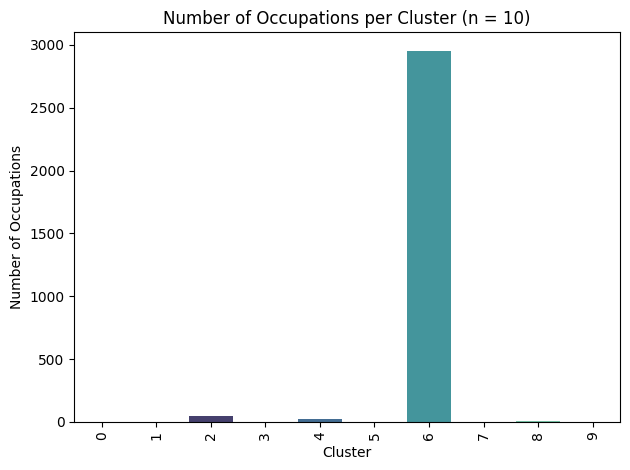

<ipython-input-3-9afd73f2f6dc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


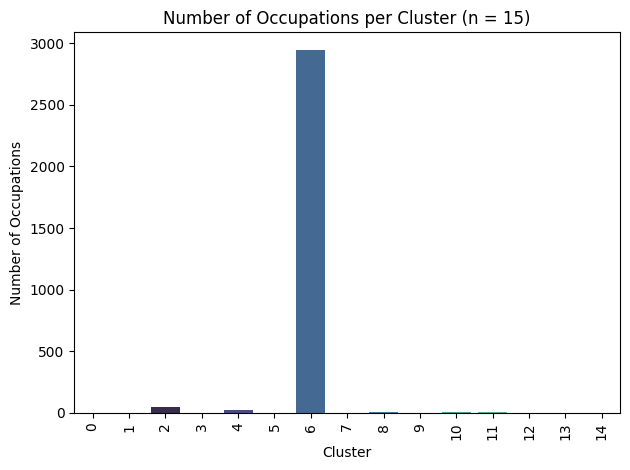

<ipython-input-3-9afd73f2f6dc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


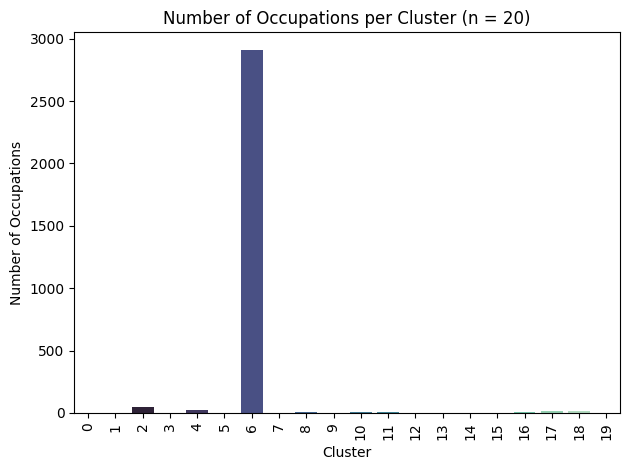

<ipython-input-3-9afd73f2f6dc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


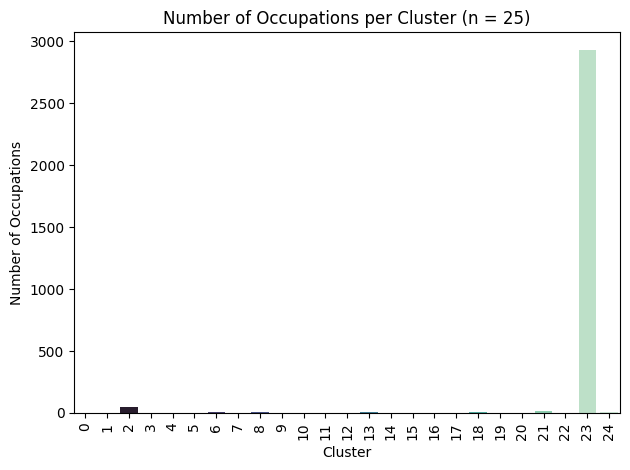

<ipython-input-3-9afd73f2f6dc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


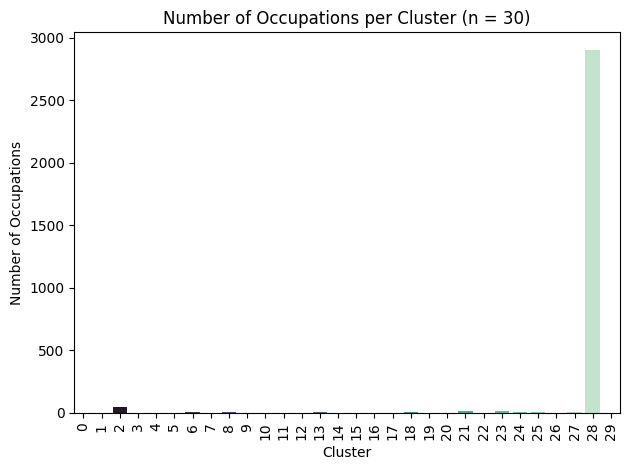

<ipython-input-3-9afd73f2f6dc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


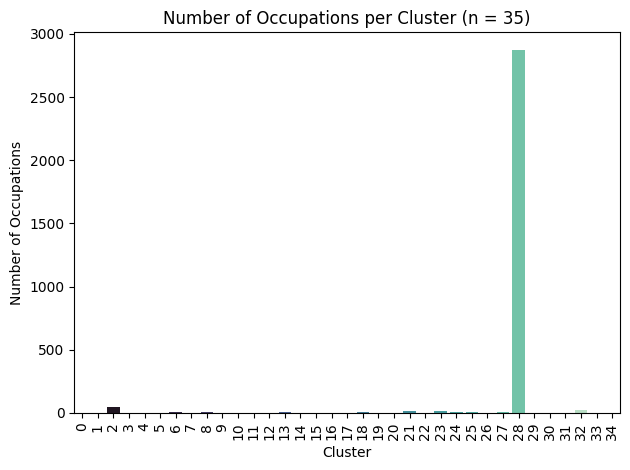

In [ ]:
#Domain of interest computing using TF-IDF + K-Means

#Add a column to final_skills with concatenated skills in a single word for TfidfVectorizer usage
final_careers["Concatenated Skills"]=final_careers['Skills'].str.replace(" ","",regex=False)
print("final_careers shape:" + str(final_careers.shape))
print("final_careers columns:" + str(final_careers.columns))

#Vectorizing the concatenated skills using TfidfVectorizer
vectorizer = TfidfVectorizer()
skills_vector = vectorizer.fit_transform(final_careers['Concatenated Skills'])
print("Skills vector matrix:" + str(skills_vector.shape))

#Applying PCA for feature reduction
reduced_skills_vector = PCA(n_components=0.95).fit_transform(skills_vector.toarray())
print("Skills reduced vector matrix:" + str(reduced_skills_vector.shape))

#Applying K-Means for different cluster sizes and plotting result to represent datapoints distribution within the clusters
cluster_sizes = [10, 15, 20, 25, 30, 35]
fitted_KMeans  = {}
cluster_numbers= {}

for n in cluster_sizes:
    km = KMeans(n_clusters=n, random_state=10)
    y = km.fit_predict(reduced_skills_vector)
    fitted_KMeans[n] = km
    cluster_numbers[n] = y

    col = f"Cluster K-{n}-TFIDF"
    final_careers[col] = y.astype(int)

    plt.figure()
    sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")
    plt.title(f"Number of Occupations per Cluster (n = {n})")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Occupations")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Skills embedding matrix:(3039, 384)
Skills reduced embedding matrix:(3039, 158)


<ipython-input-4-78df04756510>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


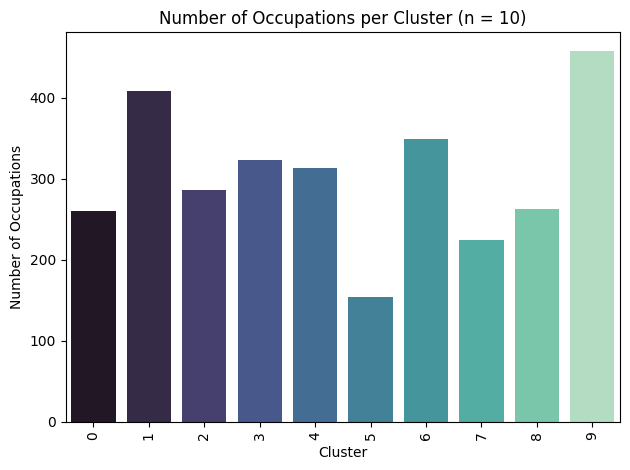

<ipython-input-4-78df04756510>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


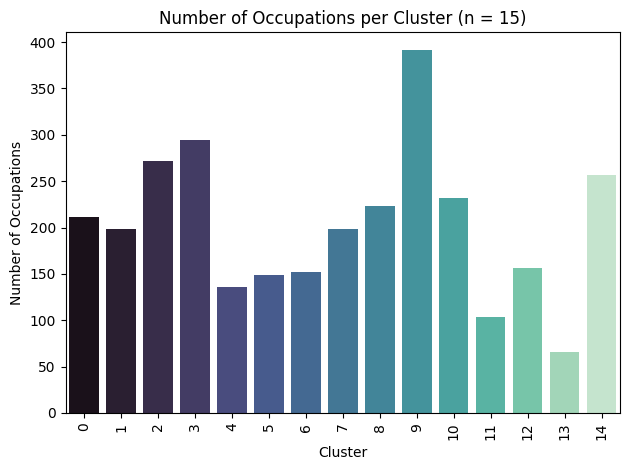

<ipython-input-4-78df04756510>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


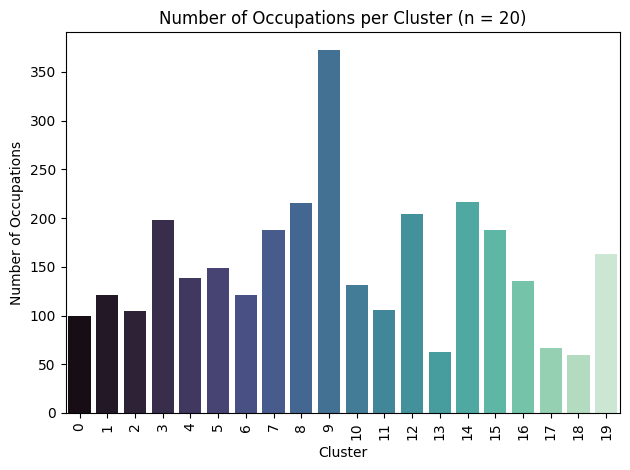

<ipython-input-4-78df04756510>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


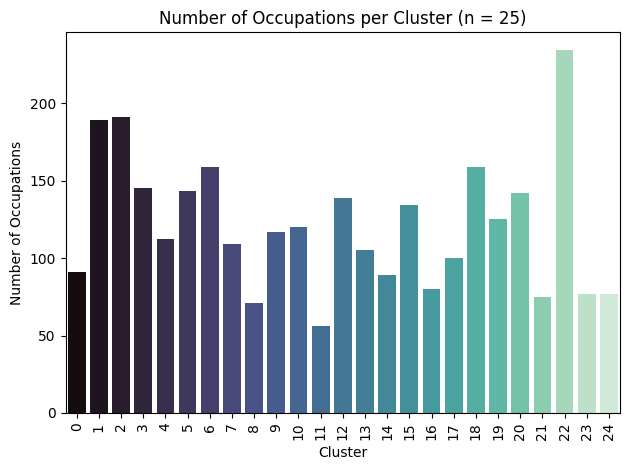

<ipython-input-4-78df04756510>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


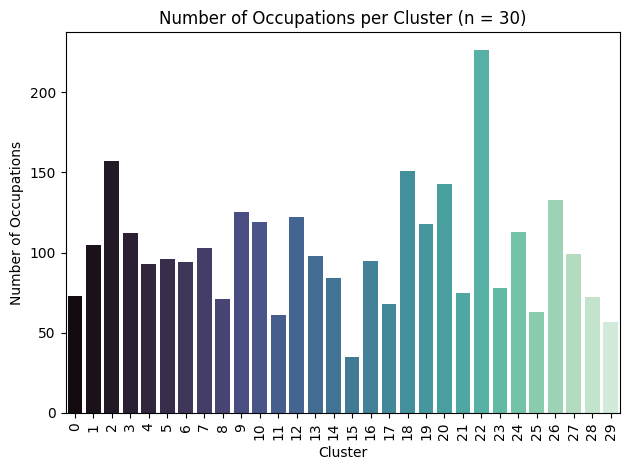

<ipython-input-4-78df04756510>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")


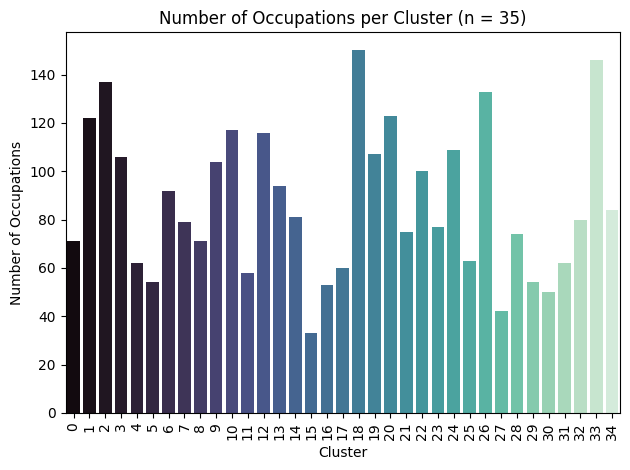

Cluster 0
1. outdoor advertising risks of elevated advertising structures apply company policies set up advertising street furniture hang advertising posters set up advertising material use personal protection equ
2. geographic areas common aviation safety regulations ensure compliance with legal requirements use different communication channels work in an aviation team follow airport safety procedures analyse dat
3. camouflage military aviation air force operations military combat techniques military weaponry military drill surveillance methods lead military troops give instructions to staff perform military oper
4. visual flight rules geographic areas aircraft flight control systems military aviation air transport law air traffic control operations air force operations aviation meteorology civil aviation regulat
5. airport planning aircraft flight control systems pre-flight procedures for IFR flights electrical systems used in transportation electronics air transport law air traffic 

,Career Path,Domain of Interest
1000,Family Social Worker,"Animation, Multimedia & Performing Arts"
1001,Family Support Worker,"Animation, Multimedia & Performing Arts"
1002,Farm Manager,Mechanical and Industrial Engineering
1003,Farm Milk Controller,Mechanical and Industrial Engineering
1004,Farrier,Mechanical and Industrial Engineering
1005,Fashion Designer,"Footwear, Textile & Leather Manufacturing"
1006,Fashion Model,Sustainable Engineering & Automotive Technologies
1007,Fat-Purification Worker,Mechanical and Industrial Engineering
1008,Fermenter Operator,Mechanical and Industrial Engineering
1009,Fertiliser Mixer,Mechanical and Industrial Engineering


In [ ]:
#Domain of interest computing using Sentence Transformer + K-Means

#Vectorizing skills using SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
skills_embedding = model.encode(final_careers["Skills"])
print("Skills embedding matrix:" + str(skills_embedding.shape))

#Saving matrix to be used in the frontend script to save runtime
np.save("../datasets/final_career_embeddings.npy", skills_embedding)

#Applying PCA for feature reduction
reduced_skills_embedding = PCA(n_components=0.95).fit_transform(skills_embedding)
print("Skills reduced embedding matrix:" + str(reduced_skills_embedding.shape))

#Applying K-Means for different cluster sizes and plotting result to represent datapoints distribution within the clusters
cluster_sizes = [10, 15, 20, 25, 30, 35]
fitted_KMeans  = {}
cluster_numbers= {}

for n in cluster_sizes:
    km = KMeans(n_clusters=n, random_state=10)
    y = km.fit_predict(reduced_skills_embedding)
    fitted_KMeans[n] = km
    cluster_numbers[n] = y

    col = f"Cluster K-{n}-EMBED"
    final_careers[col] = y.astype(int)

    plt.figure()
    sns.countplot(data=final_careers, x=col, order=sorted(final_careers[col].unique()), palette="mako")
    plt.title(f"Number of Occupations per Cluster (n = {n})")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Occupations")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

#Extract cluster skills for K=15 to surface domain of interest for each cluster
labels= final_careers["Cluster K-15-EMBED"]

for cluster_id in range(15):
    print("Cluster " + str(cluster_id))
    cluster_skills = final_careers[labels== cluster_id]

    for i, (_, row) in enumerate(cluster_skills.head().iterrows()):
        print(f"{i+1}. {row['Skills'][:200]}")

#Assign domains to each cluster based on extracted skills using chat GPT
domains = {
    0: "Environmental Management & Urban Planning",
    1: "Special Education & Instructional Technology",
    2: "Mechanical and Industrial Engineering",
    3: "Accounting, Finance & Public Administration",
    4: "Industrial Maintenance & Rubber Manufacturing",
    5: "Footwear, Textile & Leather Manufacturing",
    6: "Veterinary & Animal Biosciences",
    7: "Healthcare, Social Work & Alternative Medicine",
    8: "Aviation, Military & Outdoor Advertising",
    9: "Software Development & Digital Technologies",
    10: "Sales, Marketing & Customer Relations",
    11: "Digital Media, Advocacy & Strategic Communication",
    12: "Sustainable Engineering & Automotive Technologies",
    13: "Animation, Multimedia & Performing Arts",
    14: "Logistics, Supply Chain & Maritime Operations"
}
print("Dictionnary created")

#Map domain labels to their respective clusters using the domains dictionary
final_careers['Domain of Interest'] = final_careers['Cluster K-15-EMBED'].map(domains)
final_careers[['Career Path','Domain of Interest']][1000:1051]

In [ ]:
#Export final dataset

#Double-checking final dataset before export
print("final_careers shape:" + str(final_careers.shape))
print("final_careers columns:" + str(final_careers.columns))

#Export final_careers for future use for streamlit
final_careers.to_csv("../datasets/final_careers.csv", index=False, encoding='utf-8')

final_careers shape:(3039, 17)
final_careers columns:Index(['Career Path', 'Skills', 'Description', 'Concatenated Skills',
       'Cluster K-10-TFIDF', 'Cluster K-15-TFIDF', 'Cluster K-20-TFIDF',
       'Cluster K-25-TFIDF', 'Cluster K-30-TFIDF', 'Cluster K-35-TFIDF',
       'Cluster K-10-EMBED', 'Cluster K-15-EMBED', 'Cluster K-20-EMBED',
       'Cluster K-25-EMBED', 'Cluster K-30-EMBED', 'Cluster K-35-EMBED',
       'Domain of Interest'],
      dtype='object')
